In [13]:
!pip install xgboost pandas scikit-learn matplotlib shap
!pip install torch torchvision
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split, WeightedRandomSampler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler, random_split

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.5 MB/s eta 0:00:00


# **Gradient Boost 1st dataset using only top features**

Fighter Stats Columns: ['name', 'wins', 'losses', 'height', 'weight', 'reach', 'stance', 'age', 'SLpM', 'sig_str_acc', 'SApM', 'str_def', 'td_avg', 'td_acc', 'td_def', 'sub_avg']
Large Dataset Columns: ['event_name', 'r_fighter', 'b_fighter', 'winner', 'weight_class', 'is_title_bout', 'gender', 'method', 'finish_round', 'total_rounds', 'time_sec', 'referee', 'r_kd', 'r_sig_str', 'r_sig_str_att', 'r_sig_str_acc', 'r_str', 'r_str_att', 'r_str_acc', 'r_td', 'r_td_att', 'r_td_acc', 'r_sub_att', 'r_rev', 'r_ctrl_sec', 'r_wins_total', 'r_losses_total', 'r_age', 'r_height', 'r_weight', 'r_reach', 'r_stance', 'r_SLpM_total', 'r_SApM_total', 'r_sig_str_acc_total', 'r_td_acc_total', 'r_str_def_total', 'r_td_def_total', 'r_sub_avg', 'r_td_avg', 'b_kd', 'b_sig_str', 'b_sig_str_att', 'b_sig_str_acc', 'b_str', 'b_str_att', 'b_str_acc', 'b_td', 'b_td_att', 'b_td_acc', 'b_sub_att', 'b_rev', 'b_ctrl_sec', 'b_wins_total', 'b_losses_total', 'b_age', 'b_height', 'b_weight', 'b_reach', 'b_stance', 'b_SLpM_

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:35:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.70
              precision    recall  f1-score   support

           0       0.67      0.49      0.57       506
           1       0.72      0.84      0.78       770

    accuracy                           0.70      1276
   macro avg       0.70      0.67      0.67      1276
weighted avg       0.70      0.70      0.69      1276



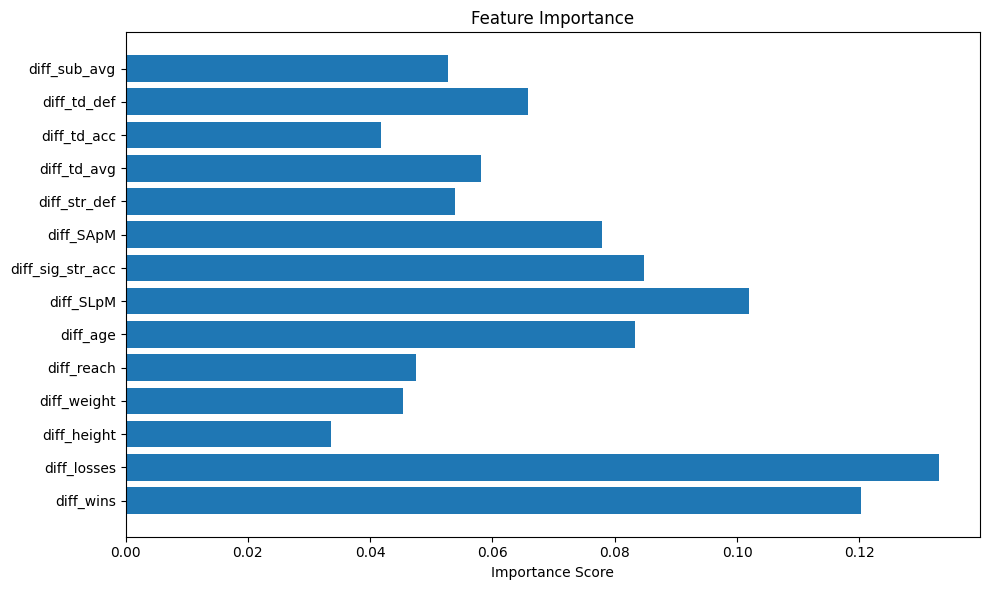

In [14]:
fighter_df = pd.read_csv("fighter_stats.csv")
print("Fighter Stats Columns:", fighter_df.columns.tolist())
fight_df = pd.read_csv("large_dataset.csv")
print("Large Dataset Columns:", fight_df.columns.tolist())

#Merge
fight_df = fight_df.merge(
    fighter_df,
    how='left',
    left_on='r_fighter',
    right_on='name',
    suffixes=('', '_r')
)

fight_df = fight_df.merge(
    fighter_df,
    how='left',
    left_on='b_fighter',
    right_on='name',
    suffixes=('', '_b')
)

fight_df = fight_df.drop(columns=['name', 'name_b'])

#Create difference features
numeric_stats = ['wins', 'losses', 'height', 'weight', 'reach', 'age', 'SLpM', 'sig_str_acc', 'SApM',
                 'str_def', 'td_avg', 'td_acc', 'td_def', 'sub_avg']

for col in numeric_stats:
    try:
        fight_df[f'diff_{col}'] = fight_df[f'{col}'] - fight_df[f'{col}_b']
    except KeyError:
        print(f"Missing: {col}, skipping")

fight_df = fight_df.dropna()

feature_cols = [col for col in fight_df.columns if col.startswith("diff_")]
X = fight_df[feature_cols]
y = (fight_df['winner'] == 'Red').astype(int)  # 1 if Red won, 0 if Blue won

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.08,
    max_depth=5,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.barh(X.columns, model.feature_importances_)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

model1 = model

# **Gradient Boost 2nd Dataset**

🔍 Columns in dataset: ['RedFighter', 'BlueFighter', 'RedOdds', 'BlueOdds', 'RedExpectedValue', 'BlueExpectedValue', 'Date', 'Location', 'Country', 'Winner', 'TitleBout', 'WeightClass', 'Gender', 'NumberOfRounds', 'BlueCurrentLoseStreak', 'BlueCurrentWinStreak', 'BlueDraws', 'BlueAvgSigStrLanded', 'BlueAvgSigStrPct', 'BlueAvgSubAtt', 'BlueAvgTDLanded', 'BlueAvgTDPct', 'BlueLongestWinStreak', 'BlueLosses', 'BlueTotalRoundsFought', 'BlueTotalTitleBouts', 'BlueWinsByDecisionMajority', 'BlueWinsByDecisionSplit', 'BlueWinsByDecisionUnanimous', 'BlueWinsByKO', 'BlueWinsBySubmission', 'BlueWinsByTKODoctorStoppage', 'BlueWins', 'BlueStance', 'BlueHeightCms', 'BlueReachCms', 'BlueWeightLbs', 'RedCurrentLoseStreak', 'RedCurrentWinStreak', 'RedDraws', 'RedAvgSigStrLanded', 'RedAvgSigStrPct', 'RedAvgSubAtt', 'RedAvgTDLanded', 'RedAvgTDPct', 'RedLongestWinStreak', 'RedLosses', 'RedTotalRoundsFought', 'RedTotalTitleBouts', 'RedWinsByDecisionMajority', 'RedWinsByDecisionSplit', 'RedWinsByDecisionUnani

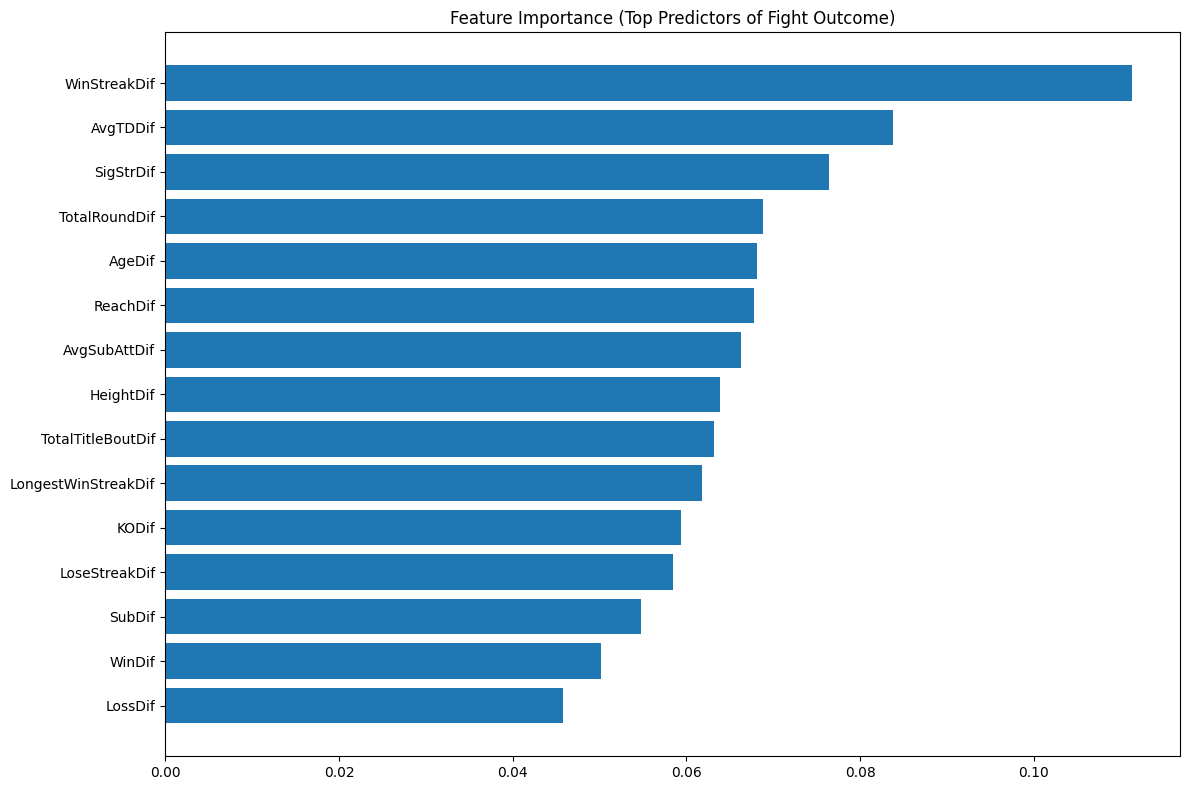

In [15]:
df = pd.read_csv("ufc-master.csv")
print("🔍 Columns in dataset:", df.columns.tolist())

#uses only relevant numeric Diff features
feature_cols = [col for col in df.columns if "Dif" in col and df[col].dtype in [np.float64, np.int64]]
required_cols = feature_cols + ["Winner"]

#Drop rows
df_filtered = df[required_cols].dropna()

X = df_filtered[feature_cols]
y = (df_filtered["Winner"] == "Red").astype(int)

print(f"✅ Dataset size: {len(X)} rows, {len(feature_cols)} features.")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Train XGBoost model
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

#eval
print(f"\n✅ Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

importances = model.feature_importances_
sorted_idx = np.argsort(importances)

plt.figure(figsize=(12, 8))
plt.barh(np.array(feature_cols)[sorted_idx], importances[sorted_idx])
plt.title("Feature Importance (Top Predictors of Fight Outcome)")
plt.tight_layout()
plt.show()

model2 = model

# **Gradient Boost 1st dataset with all features**

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Accuracy: 0.72
              precision    recall  f1-score   support

           0       0.61      0.54      0.58       514
           1       0.77      0.82      0.80       979

    accuracy                           0.72      1493
   macro avg       0.69      0.68      0.69      1493
weighted avg       0.72      0.72      0.72      1493



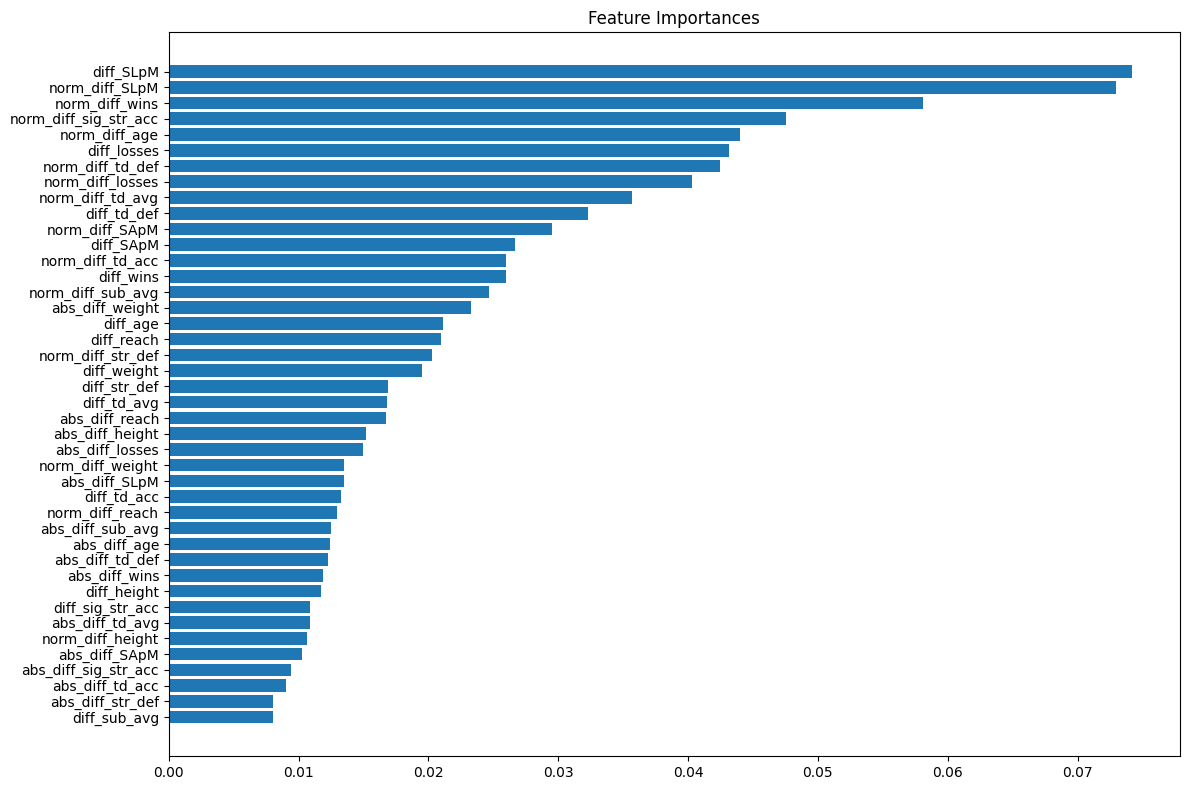

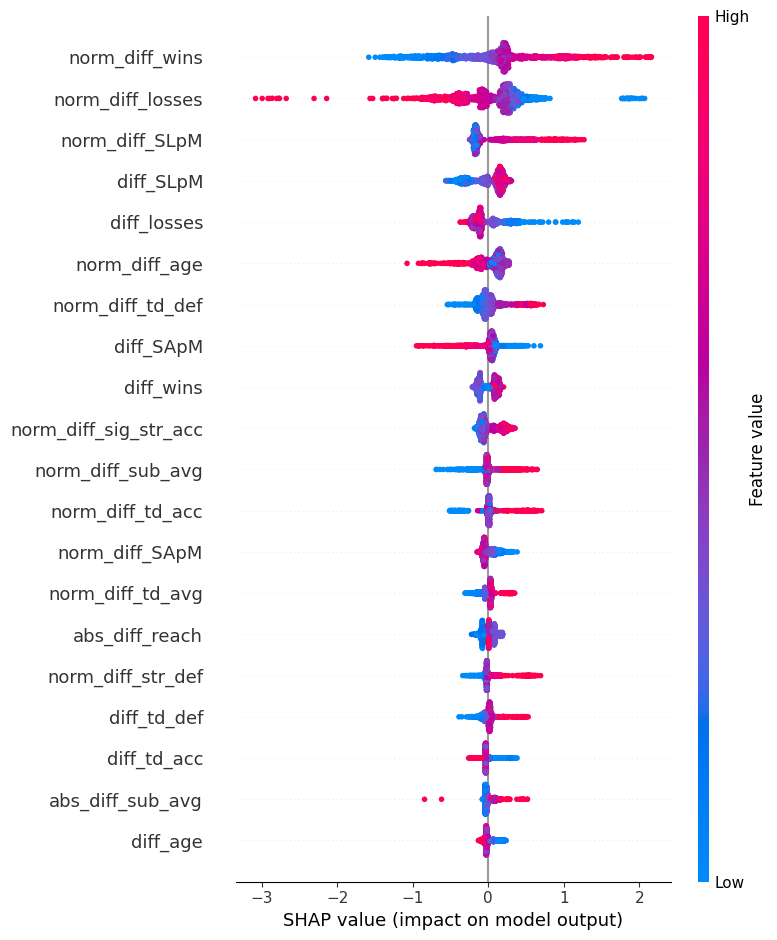

In [16]:
fighter_df = pd.read_csv("fighter_stats.csv")
fight_df = pd.read_csv("large_dataset.csv")

# Merge corner stats
fight_df = fight_df.merge(fighter_df, how='left', left_on='r_fighter', right_on='name', suffixes=('', '_r'))
fight_df = fight_df.merge(fighter_df, how='left', left_on='b_fighter', right_on='name', suffixes=('', '_b'))

# Drop duplicates
fight_df = fight_df.drop(columns=['name', 'name_b'])

#relevant stats
numeric_stats = ['wins', 'losses', 'height', 'weight', 'reach', 'age', 'SLpM', 'sig_str_acc',
                 'SApM', 'str_def', 'td_avg', 'td_acc', 'td_def', 'sub_avg']

for col in numeric_stats:
    try:
        red = fight_df[col]
        blue = fight_df[f"{col}_b"]
        fight_df[f'diff_{col}'] = red - blue
        fight_df[f'abs_diff_{col}'] = np.abs(red - blue)
        fight_df[f'norm_diff_{col}'] = (red - blue) / (red + blue + 1e-5)
    except KeyError:
        print(f"Missing {col}, skipping")

# Drop rows
fight_df = fight_df[fight_df['winner'].notna()]

imputer = SimpleImputer(strategy='median')
features = [col for col in fight_df.columns if col.startswith(('diff_', 'abs_diff_', 'norm_diff_'))]
X = pd.DataFrame(imputer.fit_transform(fight_df[features]), columns=features)

y = (fight_df['winner'] == 'Red').astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}
xgb_model = XGBClassifier(eval_metric='logloss')

search = RandomizedSearchCV(xgb_model, param_distributions=param_grid,
                            n_iter=20, cv=5, scoring='accuracy', verbose=1, random_state=42)
search.fit(X_train, y_train)
best_model = search.best_estimator_

# Predict probabilities and apply thresholding
y_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob > 0.55).astype(int)

# Eval
print("Best Parameters:", search.best_params_)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(12, 8))
sorted_idx = np.argsort(best_model.feature_importances_)
plt.barh(np.array(features)[sorted_idx], best_model.feature_importances_[sorted_idx])
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

model3 = best_model

# **Neural Network Predictor**

In [17]:
fighter_df = pd.read_csv("fighter_stats.csv")
fight_df = pd.read_csv("large_dataset.csv")
fight_df = fight_df.merge(fighter_df, how='left', left_on='r_fighter', right_on='name')
fight_df = fight_df.merge(fighter_df, how='left', left_on='b_fighter', right_on='name', suffixes=('', '_b'))
fight_df.drop(columns=['name', 'name_b'], inplace=True)

numeric_stats = ['wins', 'losses', 'height', 'weight', 'reach', 'age', 'SLpM', 'sig_str_acc',
                 'SApM', 'str_def', 'td_avg', 'td_acc', 'td_def', 'sub_avg']
for col in numeric_stats:
    try:
        red = fight_df[col]
        blue = fight_df[f"{col}_b"]
        fight_df[f'diff_{col}'] = red - blue
        fight_df[f'abs_diff_{col}'] = np.abs(red - blue)
        fight_df[f'norm_diff_{col}'] = (red - blue) / (red + blue + 1e-5)
    except KeyError:
        continue

fight_df['diff_total_wins'] = fight_df['r_wins_total'] - fight_df['b_wins_total']
fight_df['diff_total_losses'] = fight_df['r_losses_total'] - fight_df['b_losses_total']
fight_df['is_title_bout'] = fight_df['is_title_bout'].astype(int)

#cleans
fight_df = fight_df[fight_df['winner'].notna()].dropna()

feature_cols = [col for col in fight_df.columns if col.startswith(('diff_', 'abs_diff_', 'norm_diff_'))]
feature_cols += ['diff_total_wins', 'diff_total_losses', 'is_title_bout']
X = fight_df[feature_cols]
y = (fight_df['winner'] == 'Red').astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_indices = train_ds.indices if hasattr(train_ds, 'indices') else np.arange(len(train_ds))
train_targets = y_tensor[train_indices].view(-1).numpy()
class_counts = np.bincount(train_targets.astype(int))
class_weights = 1. / class_counts
weights = class_weights[train_targets.astype(int)]
sampler = WeightedRandomSampler(weights, len(train_targets), replacement=True)

train_dl = DataLoader(train_ds, batch_size=32, sampler=sampler)
test_dl = DataLoader(test_ds, batch_size=32)

# Neural network
class FightPredictor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(0.01),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(0.01),
            nn.Dropout(0.1),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(0.01),
            nn.Dropout(0.01),

            nn.Linear(64, 32),
            nn.ReLU(0.01),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# Training setup
model = FightPredictor(X_tensor.shape[1])
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

# Training loop
losses = []
for epoch in range(50):
    model.train()
    total_loss = 0
    for xb, yb in train_dl:
        logits = model(xb)
        loss = loss_fn(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()
    avg_loss = total_loss / len(train_dl)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

plt.plot(losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

#eval
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        logits = model(xb)
        probs = torch.sigmoid(logits)
        all_preds.extend(probs.numpy())
        all_labels.extend(yb.numpy())

y_pred = (np.array(all_preds) > 0.5).astype(int)
print(f"Accuracy: {accuracy_score(all_labels, y_pred):.2f}")
print(classification_report(all_labels, y_pred))
print(f"AUC Score: {roc_auc_score(all_labels, all_preds):.2f}")

model4 = model

Epoch 1, Loss: 0.6162, LR: 0.049863
Epoch 2, Loss: 0.5993, LR: 0.049454
Epoch 3, Loss: 0.5886, LR: 0.048776


KeyboardInterrupt: 

# **Gradient Boost ALL FEATURES ON BIG DATASET**

✅ Loaded large_dataset.csv


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:37:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Accuracy: 0.89
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       493
           1       0.91      0.91      0.91       786

    accuracy                           0.89      1279
   macro avg       0.89      0.89      0.89      1279
weighted avg       0.89      0.89      0.89      1279



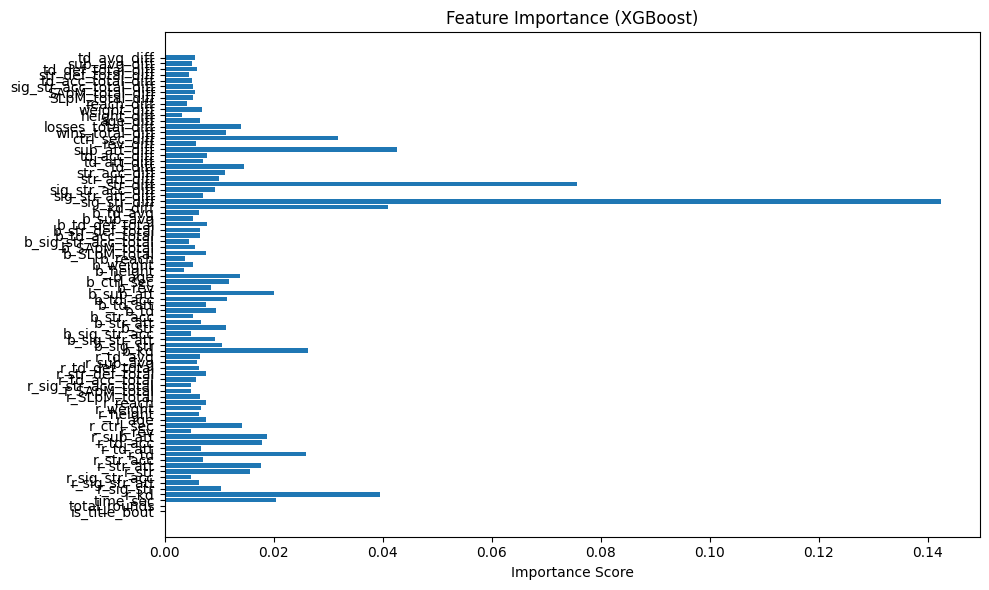

In [18]:
fight_df = pd.read_csv("large_dataset.csv")
print("✅ Loaded large_dataset.csv")

#Exclude only outcome-leaking columns
leak_columns = [
    'winner', 'method', 'finish_round',
    'r_wins_total', 'r_losses_total', 'b_wins_total', 'b_losses_total',
    'r_fighter', 'b_fighter', 'event_name', 'referee'
]

#Select numeric features and remove leaks
numeric_cols = fight_df.select_dtypes(include=[np.float64, np.int64]).columns.tolist()
feature_cols = [col for col in numeric_cols if col not in leak_columns]

# Drop rows with NaNs in selected features as well as who wins
fight_df = fight_df.dropna(subset=feature_cols + ['winner'])

X = fight_df[feature_cols]
y = (fight_df['winner'] == 'Red').astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#trains XGBoost model
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.08,
    max_depth=5,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

#eval
y_pred = model.predict(X_test)
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.barh(X.columns, model.feature_importances_)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

#model6 = model

# **GRADIENT BOOSTED DIFF BASED FEATURES LARGE DATASET**

✅ Loaded large_dataset.csv
✅ Accuracy: 0.89
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       493
           1       0.91      0.91      0.91       786

    accuracy                           0.89      1279
   macro avg       0.89      0.89      0.89      1279
weighted avg       0.89      0.89      0.89      1279



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:37:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


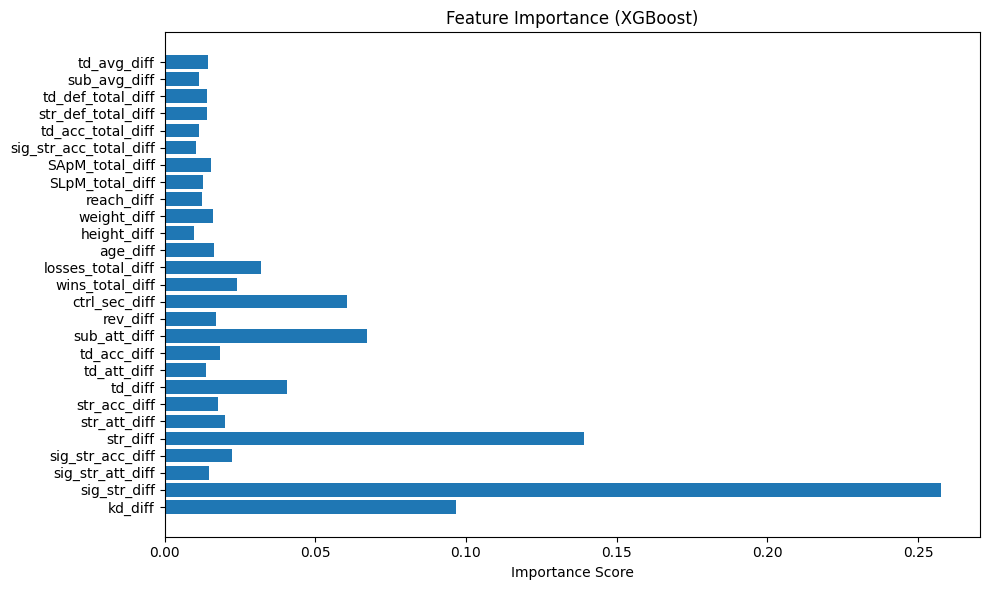

In [19]:
fight_df = pd.read_csv("large_dataset.csv")
print("✅ Loaded large_dataset.csv")

# Selects only diff-based numerical features
feature_cols = [col for col in fight_df.columns if col.endswith("_diff") and fight_df[col].dtype in [np.float64, np.int64]]

# Drop rows with NaNs in selected features as well as who wins
fight_df = fight_df.dropna(subset=feature_cols + ['winner'])

X = fight_df[feature_cols]
y = (fight_df["winner"] == "Red").astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Trains XGBoost model
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.08,
    max_depth=5,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

#eval
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.barh(X.columns, model.feature_importances_)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

model5 = model

# **USER INPUT FOR MAKING NEW PREDICTIONS**

In [ ]:
feature_descriptions = [
    "Avg Knockdowns Difference",
    "Avg Significant Strikes Landed Difference",
    "Avg Significant Strikes Attempted Difference",
    "Avg Significant Strikes Accuracy Difference",
    "Avg Total Strikes Landed Difference",
    "Avg Total Strikes Attempted Difference",
    "Avg Total Strikes Accuracy Difference",
    "Avg Takedowns Landed Difference",
    "Avg Takedowns Attempted Difference",
    "Avg Takedown Accuracy Difference",
    "Avg Submission Attempts Difference",
    "Avg Reversals Difference",
    "Avg Control Time (in seconds) Difference",
    "Total Career Wins Difference",
    "Total Career Losses Difference",
    "Age Difference",
    "Height Difference (in cm)",
    "Weight Difference (in lbs)",
    "Reach Difference (in cm)",
    "Significant Strikes Landed per Minute (SLpM) Difference",
    "Significant Strikes Absorbed per Minute (SApM) Difference",
    "Career Average Significant Strike Accuracy Difference",
    "Career Average Takedown Accuracy Difference",
    "Career Striking Defense Percentage Difference",
    "Career Takedown Defense Percentage Difference",
    "Avg Submission Average per 15 Minutes Difference",
    "Avg Takedowns Landed per 15 Minutes Difference"
]
print("Below are the different features the model uses for analysis\n")
print(feature_cols)
print(feature_descriptions)
print("\n")
input_array = []

print("Enter name for First Fighter ->")
name1 = input()
print("Enter name for Second Fighter ->")
name2 = input()

for i in range(len(feature_cols)):
    print(f"Input feature value or leave empty if unknown -> {col}")
    col_trimmed = feature_cols[i][:-5]
    print("enter " +name1 +"s " +col_trimmed)
    print(feature_descriptions[i] +" = ")
    inputted1 = input()
    print("enter " +name2 +"s " +col_trimmed)
    print(feature_descriptions[i] +" = ")
    inputted2 = input()
    final_input = double(inputted1) - double(inputted2)
    if inputted.strip() == "":
        input_array.append(0.0)
    else:
        input_array.append(float(final_input))

print("\n Fully inputted array:")
print(input_array)

user_input = np.array(input_array).reshape(1, -1)

pred5 = model5.predict(user_input)[0]

print(f"\n🏆 Predicted Winner: {'Red' if pred5 == 1 else 'Blue'}")

# **ARRAY INPUT FOR NEW PREDICTIONS**




In [21]:
print("Enter name for First Fighter ->")
name1 = input()
print("Enter name for Second Fighter ->")
name2 = input()

islam_makhachev_stats = [
    0.0,    # d_diff (no recent decision controversy data available)
    2.63,   # sig_str_landed_diff (SLpM)
    4.5,    # sig_str_att_diff (estimated based on his accuracy)
    58,     # sig_str_acc_diff
    3.0,    # total_str_landed_diff (approx total strikes per minute)
    5.2,    # total_str_att_diff (estimated)
    58,     # total_str_acc_diff
    3.46,   # td_landed_diff
    5.5,    # td_att_diff (estimated based on attempts per 15 min)
    62,     # td_acc_diff
    0.8,    # sub_att_diff
    20,     # rev_diff (estimated low; not a high-reversal fighter)
    180,    # ctrl_sec_diff (estimated total control time in sec per 15 min)
    27,     # wins_total_diff
    1,      # losses_total_diff
    33,     # age_diff
    0,      # height_diff
    0,      # weight_diff
    0.0,    # reach_diff
    2.63,   # SLpM_total_diff
    1.55,   # SApM_total_diff
    58,     # sig_str_acc_total_diff
    62,     # td_acc_total_diff
    61,     # str_def_total_diff
    90,     # td_def_total_diff
    0.8,    # sub_avg_diff
    3.46    # td_avg_diff
]

ilia_topuria_stats = [
    0.0,    # d_diff
    4.69,   # sig_str_landed_diff (SLpM)
    10.0,   # sig_str_att_diff (estimated)
    47,     # sig_str_acc_diff
    5.0,    # total_str_landed_diff
    10.6,   # total_str_att_diff (estimated)
    47,     # total_str_acc_diff
    2.19,   # td_landed_diff
    3.9,    # td_att_diff
    56,     # td_acc_diff
    0.8,    # sub_att_diff
    25,     # rev_diff (estimated)
    120,    # ctrl_sec_diff
    16,     # wins_total_diff
    0,      # losses_total_diff
    28,     # age_diff
    -3,     # height_diff (compared to Islam)
    -10,    # weight_diff (compared to Islam’s lightweight)
    -1.5,   # reach_diff (69" vs 70.5")
    4.69,   # SLpM_total_diff
    3.84,   # SApM_total_diff
    47,     # sig_str_acc_total_diff
    56,     # td_acc_total_diff
    64,     # str_def_total_diff
    92,     # td_def_total_diff
    0.8,    # sub_avg_diff
    2.19    # td_avg_diff
]


# Zero out stat where other is empty
islam_makhachev_stats = [
    v if d != 0 else 0
    for v, d in zip(islam_makhachev_stats, ilia_topuria_stats)
]

ilia_topuria_stats = [
    v if d != 0 else 0
    for v, d in zip(ilia_topuria_stats, islam_makhachev_stats)
]

#change this if array name above changes
array1 = islam_makhachev_stats
array2 = ilia_topuria_stats

array3 = []

for i in range(len(array1)):
  array3.append(array1[i] - array2[i])

user_input = np.array(array3).reshape(1, -1)

pred5 = model5.predict(user_input)[0]

print(f"\n Predicted Winner: {name1 if pred5 == 1 else name2}")

Enter name for First Fighter ->
islam
Enter name for Second Fighter ->
ilia

 Predicted Winner: islam


In [23]:
print("Enter name for First Fighter ->")
name1 = input()
print("Enter name for Second Fighter ->")
name2 = input()
belal_muhammad_stats = [
    0.06,  # d_diff
    18,    # sig_str_landed_diff
    15,    # sig_str_att_diff
    57,    # sig_str_acc_diff
    20,    # total_str_landed_diff
    25,    # total_str_att_diff
    13,    # total_str_acc_diff
    15,    # td_landed_diff
    6.7,   # td_att_diff
    3.8,   # td_acc_diff
    2.9,   # sub_att_diff
    58,    # rev_diff
    37,    # ctrl_sec_diff
    7,     # wins_total_diff
    70,    # losses_total_diff
    1.8,   # age_diff
    0.8,   # height_diff
    0.0,   # weight_diff
    -0.2,  # reach_diff
    30,    # SLpM_total_diff
    168,   # SApM_total_diff
    182,   # sig_str_acc_total_diff
    145,   # td_acc_total_diff
    35,    # str_def_total_diff
    26,    # td_def_total_diff
    4,     # sub_avg_diff
    15     # td_avg_diff
]

jack_della_maddalena_stats = [
    0,     # d_diff
    0.09,  # sig_str_landed_diff
    0.15,  # sig_str_att_diff
    53,    # sig_str_acc_diff
    0,     # total_str_landed_diff
    0,     # total_str_att_diff
    0,     # total_str_acc_diff
    0,     # td_landed_diff
    4.2,   # td_att_diff
    4.1,   # td_acc_diff
    0.1,   # sub_att_diff
    50,    # rev_diff
    33,    # ctrl_sec_diff
    0,     # wins_total_diff
    0,     # losses_total_diff
    0,     # age_diff
    0,     # height_diff
    0,     # weight_diff
    0,     # reach_diff
    180,   # SLpM_total_diff
    184,   # SApM_total_diff
    0,     # sig_str_acc_total_diff
    145,   # td_acc_total_diff
    30,    # str_def_total_diff
    5,     # td_def_total_diff
    2,     # sub_avg_diff
    0      # td_avg_diff
]


# Zero out stat where other is empty
belal_muhammad_stats = [
    v if d != 0 else 0
    for v, d in zip(belal_muhammad_stats, jack_della_maddalena_stats)
]

jack_della_maddalena_stats = [
    v if d != 0 else 0
    for v, d in zip(jack_della_maddalena_stats, belal_muhammad_stats)
]

#change this if array name above changes
array1 = belal_muhammad_stats
array2 = jack_della_maddalena_stats

array3 = []

for i in range(len(array1)):
  array3.append(array1[i] - array2[i])

user_input = np.array(array3).reshape(1, -1)

pred5 = model5.predict(user_input)[0]

print(f"\n Predicted Winner: {name1 if pred5 == 1 else name2}")

Enter name for First Fighter ->
belal
Enter name for Second Fighter ->
jack

 Predicted Winner: belal


# **STORED DATA. DO NOT RUN**

In [ ]:
# HERE ARE SOME OF THE PAST STATS USED
#PREDICTED VOLK WINNING OVER DIEGO CORRECT
#PREDICTED IAN GARYY WINNING OVER PRACHEK CORRECT
#PREDICTED BELAL WINNING OVER JACK
#PREDICTED ISLAM WINNING OVER ILLIA

islam_makhachev_stats = [
    0.0,    # d_diff (no recent decision controversy data available)
    2.63,   # sig_str_landed_diff (SLpM)
    4.5,    # sig_str_att_diff (estimated based on his accuracy)
    58,     # sig_str_acc_diff
    3.0,    # total_str_landed_diff (approx total strikes per minute)
    5.2,    # total_str_att_diff (estimated)
    58,     # total_str_acc_diff
    3.46,   # td_landed_diff
    5.5,    # td_att_diff (estimated based on attempts per 15 min)
    62,     # td_acc_diff
    0.8,    # sub_att_diff
    20,     # rev_diff (estimated low; not a high-reversal fighter)
    180,    # ctrl_sec_diff (estimated total control time in sec per 15 min)
    27,     # wins_total_diff
    1,      # losses_total_diff
    33,     # age_diff
    0,      # height_diff
    0,      # weight_diff
    0.0,    # reach_diff
    2.63,   # SLpM_total_diff
    1.55,   # SApM_total_diff
    58,     # sig_str_acc_total_diff
    62,     # td_acc_total_diff
    61,     # str_def_total_diff
    90,     # td_def_total_diff
    0.8,    # sub_avg_diff
    3.46    # td_avg_diff
]

ilia_topuria_stats = [
    0.0,    # d_diff
    4.69,   # sig_str_landed_diff (SLpM)
    10.0,   # sig_str_att_diff (estimated)
    47,     # sig_str_acc_diff
    5.0,    # total_str_landed_diff
    10.6,   # total_str_att_diff (estimated)
    47,     # total_str_acc_diff
    2.19,   # td_landed_diff
    3.9,    # td_att_diff
    56,     # td_acc_diff
    0.8,    # sub_att_diff
    25,     # rev_diff (estimated)
    120,    # ctrl_sec_diff
    16,     # wins_total_diff
    0,      # losses_total_diff
    28,     # age_diff
    -3,     # height_diff (compared to Islam)
    -10,    # weight_diff (compared to Islam’s lightweight)
    -1.5,   # reach_diff (69" vs 70.5")
    4.69,   # SLpM_total_diff
    3.84,   # SApM_total_diff
    47,     # sig_str_acc_total_diff
    56,     # td_acc_total_diff
    64,     # str_def_total_diff
    92,     # td_def_total_diff
    0.8,    # sub_avg_diff
    2.19    # td_avg_diff
]


belal_muhammad_stats = [
    0.06,  # d_diff
    18,    # sig_str_landed_diff
    15,    # sig_str_att_diff
    57,    # sig_str_acc_diff
    20,    # total_str_landed_diff
    25,    # total_str_att_diff
    13,    # total_str_acc_diff
    15,    # td_landed_diff
    6.7,   # td_att_diff
    3.8,   # td_acc_diff
    2.9,   # sub_att_diff
    58,    # rev_diff
    37,    # ctrl_sec_diff
    7,     # wins_total_diff
    70,    # losses_total_diff
    1.8,   # age_diff
    0.8,   # height_diff
    0.0,   # weight_diff
    -0.2,  # reach_diff
    30,    # SLpM_total_diff
    168,   # SApM_total_diff
    182,   # sig_str_acc_total_diff
    145,   # td_acc_total_diff
    35,    # str_def_total_diff
    26,    # td_def_total_diff
    4,     # sub_avg_diff
    15     # td_avg_diff
]

jack_della_maddalena_stats = [
    0,     # d_diff
    0.09,  # sig_str_landed_diff
    0.15,  # sig_str_att_diff
    53,    # sig_str_acc_diff
    0,     # total_str_landed_diff
    0,     # total_str_att_diff
    0,     # total_str_acc_diff
    0,     # td_landed_diff
    4.2,   # td_att_diff
    4.1,   # td_acc_diff
    0.1,   # sub_att_diff
    50,    # rev_diff
    33,    # ctrl_sec_diff
    0,     # wins_total_diff
    0,     # losses_total_diff
    0,     # age_diff
    0,     # height_diff
    0,     # weight_diff
    0,     # reach_diff
    180,   # SLpM_total_diff
    184,   # SApM_total_diff
    0,     # sig_str_acc_total_diff
    145,   # td_acc_total_diff
    30,    # str_def_total_diff
    5,     # td_def_total_diff
    2,     # sub_avg_diff
    0      # td_avg_diff
]


volkanovski_stats = [
    0.06,  # d_diff
    18,    # sig_str_landed_diff
    15,    # sig_str_att_diff
    57,    # sig_str_acc_diff
    20,    # total_str_landed_diff
    25,    # total_str_att_diff
    13,    # total_str_acc_diff
    15,    # td_landed_diff
    6.7,   # td_att_diff
    3.8,   # td_acc_diff
    2.9,   # sub_att_diff
    58,    # rev_diff
    37,    # ctrl_sec_diff
    7,     # wins_total_diff
    70,    # losses_total_diff
    1.8,   # age_diff
    0.8,   # height_diff
    0.0,   # weight_diff
    -0.2,  # reach_diff
    30,    # SLpM_total_diff
    168,   # SApM_total_diff
    182,   # sig_str_acc_total_diff
    145,   # td_acc_total_diff
    35,    # str_def_total_diff
    26,    # td_def_total_diff
    4,     # sub_avg_diff
    15     # td_avg_diff
]

diego_lopes_stats = [
    0,     # d_diff
    0.09,  # sig_str_landed_diff
    0.15,  # sig_str_att_diff
    53,    # sig_str_acc_diff
    0,     # total_str_landed_diff
    0,     # total_str_att_diff
    0,     # total_str_acc_diff
    0,     # td_landed_diff
    4.2,   # td_att_diff
    4.1,   # td_acc_diff
    0.1,   # sub_att_diff
    50,    # rev_diff
    33,    # ctrl_sec_diff
    0,     # wins_total_diff
    0,     # losses_total_diff
    0,     # age_diff
    0,     # height_diff
    0,     # weight_diff
    0,     # reach_diff
    180,   # SLpM_total_diff
    184,   # SApM_total_diff
    0,     # sig_str_acc_total_diff
    145,   # td_acc_total_diff
    30,    # str_def_total_diff
    5,     # td_def_total_diff
    2,     # sub_avg_diff
    0      # td_avg_diff
]
